## **CT1-MLOPS COURSE GROUP ASSIGNMENT** ##

> **Use Case ::** Predicting Student Grade

> **Dataset Source ::** Kaggle - https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset/data

> **Group No. ::** 12

## **STEP 8 :: MODEL DEPLOYMENT AND FAST API**

In [4]:
!pip install wandb
!pip install fastapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00


In [5]:
# Import necessary library and modules
import pandas as pd
import numpy as np
from joblib import load
from flask import Flask, jsonify, request
import json
import requests
import wandb
from fastapi import FastAPI, HTTPException
from joblib import load

from contextlib import asynccontextmanager
from pydantic import BaseModel
from multiprocessing import Process
from threading import Thread

# Using "warnings" module to suppress/ignore warnings thrown by methods
import warnings
warnings.filterwarnings("ignore")

### **V.  Model Deployment**
> In this stage we will be fetching the most suitable prediction model from mlflow and deploy.

#### **Get the Model from Weights and Biasis Tracker**
> From the previous steps we are able to see that the most suitable model is of **"Gradient Boost Classifier"** and hence we will be fetching the *Pickle File* for lastest version of this model from Weights and Biasis Tracker.
>> **Project Name :** Student_Grade_Predictor

>> **Experimant Name :** FinalModel

>> **Artifact Path :** Student_GradeClass_Predictor


**Steps Taken -**
1. We will store the W&B authtoken used to authorize as a environment parameter.
2. A new run is establised to the W&B with job as inference to fetch the model (logged as artifact) and download it onto the local machine. The path where model is downloaded is saved to another variable.
3. From the local storage the model is loaded into colab.

In [1]:
# Storing the W&B authkey as an environment variable to ease of accessing
import os
os.environ["WANDB_API_KEY"] = "0a420cd939204c34c67ea714fe3f05c9f4f4e224"

In [6]:
# Initialize a new run to performance "inference" task - in this case fetch the artifact- for the project 'Student_Grade_Predictor'
run = wandb.init(project="Student_Grade_Predictor", job_type="inference")

# Fetch the artifact i.e., the model from W&B
artifact = run.use_artifact("Student_GradeClass_Predictor:latest")

# Retrieves the path to the downloaded artifact file in our machine
model_path = artifact.file()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sriramgopal (sriramgopal-indian-school-of-business). Use `wandb login --relogin` to force relogin


In [7]:
# Load the model retrieved from W&B to 'loaded_model'
loaded_model = load(model_path)
print(loaded_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['StudyTimeWeekly',
                                                   'Absences']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Ethnicity',
                                                   'ParentalEducation',
                                                   'Tutoring',
                                                   'ParentalSupport',
                                                   'Extracurricular', 'Sports',


### **VI. Fast API**
> In this stage we will be creating a Restful API to which an webservice will be posting feature values (such as Age, Gender, Parental Support, Study Time etc.) as input and get an predicted GPA Grade in reponse.
>> The API will be exposed at an endpoint/port for access:: **--host 0.0.0.0 (localhost) --port 8000**

**About NGROK ::**

Ngrok is a cross-platform application that creates secure tunnels (paths) to localhost machine. It enables developers to expose a local development server to the Internet with minimal effort. The software makes your locally-hosted web server (like computer, laptop, rasbery PI) appear to be hosted on a subdomain of ngrok.com, meaning that no public IP or domain name on the local machine is needed.

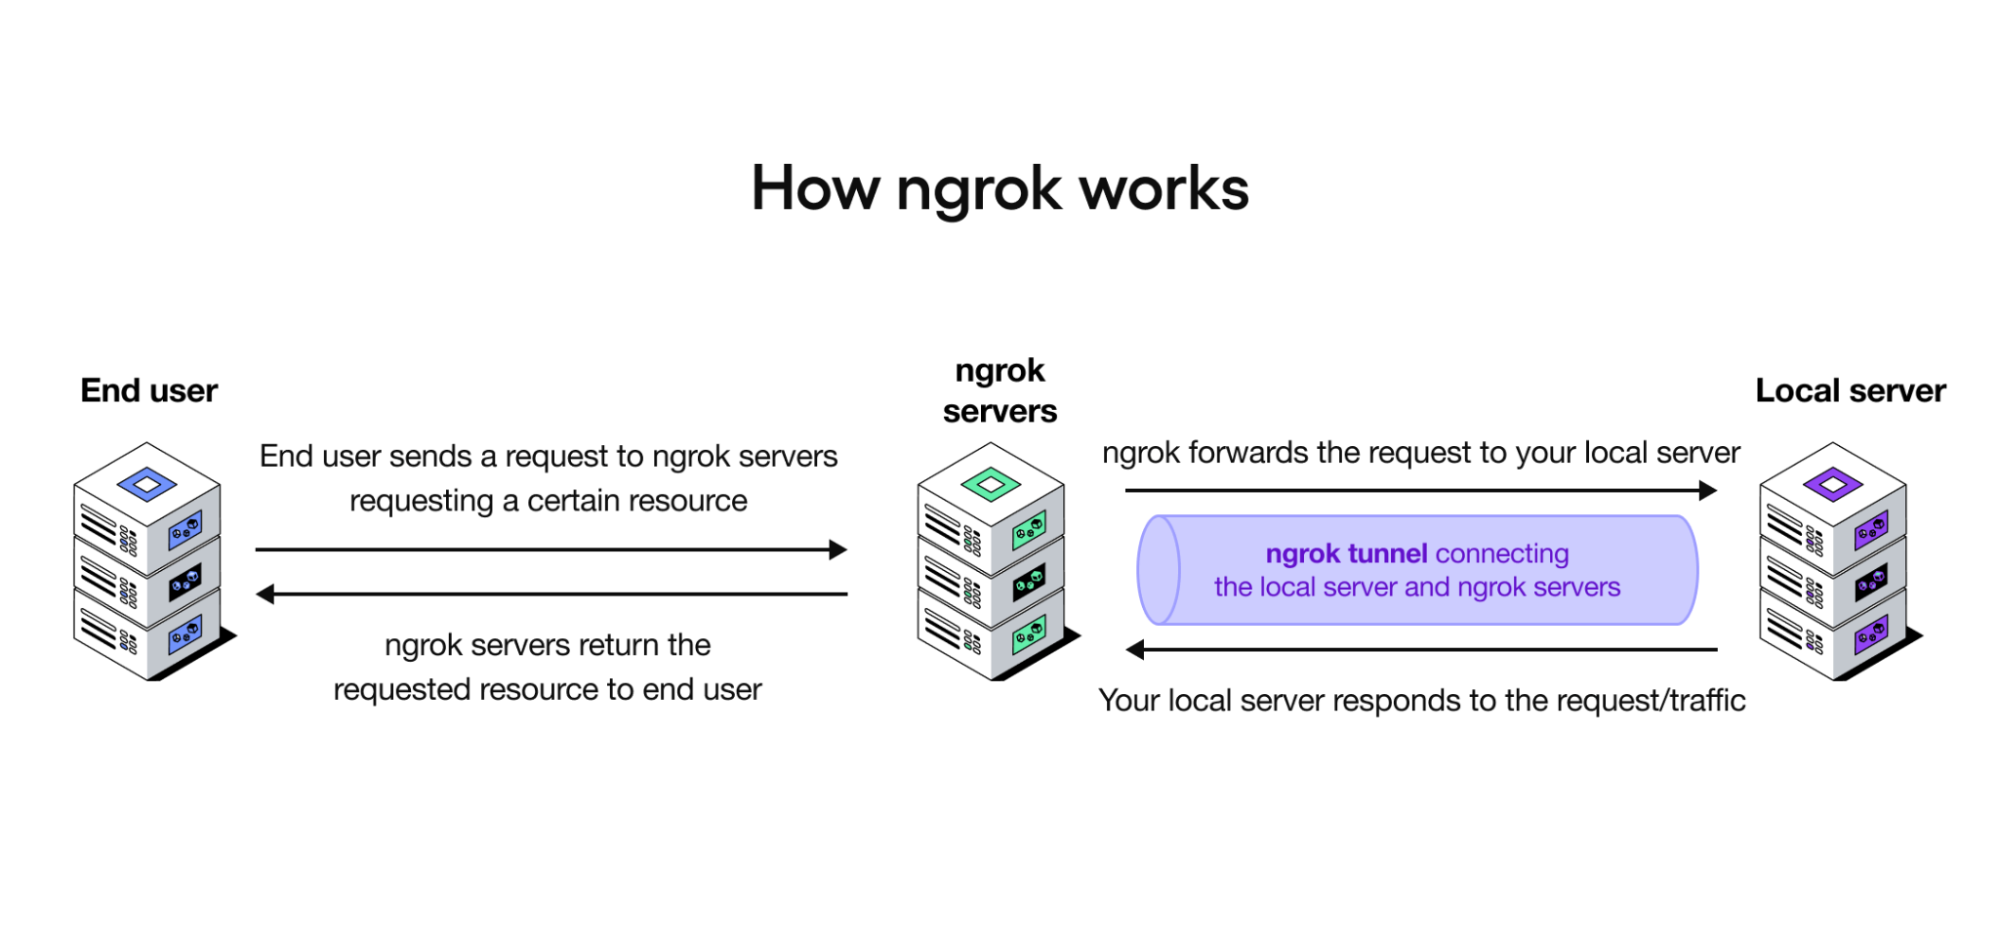

**source -** *https://www.pubnub.com/guides/what-is-ngrok/*

**Steps Taken -**
1. We set the ngrok authtoken that will be required for authentication of user.
2. We initialize FastAPI and define the schema of the values that will be passed as the parameter in the request body (JSON) of the API.
3. We define a application that will be predict the score basis the parameter passed in the request.
> The request shall be directed to the application when the context path of the request URL is "/predict".
4. The response received from the application will be posted given back over the same connection (it is a Sync API call).

**Use of NGROK ::**
- We use ngrok to create a secure endpoint to which an external user can post its request. Ngrok creates a secure tunnel between the public exposed endpoint and the local server (0.0.0.0:8000) end point on which the service is running.
- Once the traffic/request hits the public endpoint, ngrok forwards the traffic over the secure channel thereby abstracting the internal working endpoint from outside world.

**Using Uvicorn ::**
We have used the uvicorn module to local start a server at our desired endpoint of 0.0.0.0:8000.

In [8]:
pip install fastapi uvicorn pyngrok --no-warn-script-location

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.4 MB/s eta 0:00:00


In [9]:
from pyngrok import ngrok

In [10]:
# Storing the ngrok auth-token which will be later used to authorize the web user posting the API request when connecting to the API service hosted at port 8000
ngrok.set_auth_token("2qAhlR3XOqbkQttnZLrq9Icn0Wk_7WGrypNG3fqFX8kZ5Y34C")

In [11]:
app = FastAPI()

# Defining input data schema
class PredictionRequest(BaseModel):
    Age : int
    Gender : int
    Ethnicity : int
    ParentalEducation : int
    StudyTimeWeekly : float
    Absences : int
    Tutoring : int
    ParentalSupport : int
    Extracurricular : int
    Sports : int
    Music : int
    Volunteering : int

# Prediction endpoint
@app.post("/predict")
def predict(input_data: PredictionRequest):
    try:
        # Convert input data to a dictionary for prediction
        input_dict = input_data.dict()

        df = pd.DataFrame(input_dict, index = [0])

        # Call the model's prediction method
        prediction = loaded_model.predict(df)

        # Mapping Predicted output value to Grade Class
        match  prediction[0]:
            case 0:
                pred_grade = "A"
            case 1:
                pred_grade = "B"
            case 2:
                pred_grade = "C"
            case 3:
                pred_grade = "D"
            case 4:
                pred_grade = "E"

        # Return the prediction result
        return {f"Estimated Grade Class :: {pred_grade}"}

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {e}")

In [12]:
import uvicorn
# Starting a local server at the desired endpoind to host the service/application
def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

# Threading is used to allow the service to run without interupting the main program that is being executed
thread = Thread(target=run_server, daemon=True)
thread.start()

INFO:     Started server process [381]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [13]:
# Expose the FastAPI app
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

Public URL: NgrokTunnel: "https://4125-34-42-223-240.ngrok-free.app" -> "http://localhost:8000"


**Exporting the Public URL**

In [14]:
# Exporting the Ngrok Public (secure link) URL to a file for using in Streamlit
with open("ngrokPublicURL.txt", "w") as f:
    f.write(public_url.public_url)

#### **Testing the API endpoint**

**Steps Performed -**
1. Once the service is up and running and secure tunnel is established between the public endpoing and local endpoint, we create a manual request and post it to the verify the end point is working.
2. Define a payload (JSON) with all the input parameter required to predict the Grade Class.
3. Post the request to the public expoed end point using "requests" method. Store the response received to 'resp' variable and display it.

In [15]:
# Define the parameter values to be passed in the request
payload = {
     "Age":18,
      "Gender":1,
      "Ethnicity":2,
      "ParentalEducation":2,
      "StudyTimeWeekly":0.2602,
      "Absences":15,
      "Tutoring":0,
      "ParentalSupport":3,
      "Extracurricular":1,
      "Sports":1,
      "Music":1,
      "Volunteering":0
}

In [16]:
# Make a POST request to the FastAPI server
resp = requests.post(public_url.public_url + "/predict", json=payload)

# Printing the status code
print(f"Status: {resp.status_code}")

# Printing the headers
print(f"Header Data: {resp.headers}")

# Print the content of the response (the actual prediction)
print(f"Response Received: {resp.text}")

INFO:     34.42.223.240:0 - "POST /predict HTTP/1.1" 200 OK
Status: 200
Header Data: {'Content-Length': '30', 'Content-Type': 'application/json', 'Date': 'Sun, 15 Dec 2024 09:58:44 GMT', 'Ngrok-Agent-Ips': '34.42.223.240', 'Server': 'uvicorn'}
Response Received: ["Estimated Grade Class :: D"]
